In [1]:
%matplotlib inline

from pathlib import Path
import json
import sys
sys.path.append("../../")

import anamic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
from scipy import ndimage

data_dir = Path('/home/hadim/Drive/Data/Fake Microtubules/anamic')

/home/hadim/local/conda/envs/ws/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
../../anamic/transformations.py:1916: UserWarning: No module named 'anamic._transformations'
  warnings.warn(str(err))


In [2]:
condition = "taper_length_nm_1500"
fnames = list((data_dir / condition).glob("*.tif"))

index = 2
fname = fnames[index]

# Open the image
im = tifffile.imread(str(fname))

# Load metadata
metadata = json.load(open(fname.with_suffix('.json')))

# Get microtubule tip coordinates
tip_start = np.array(metadata['tip_start'])
tip_end = np.array(metadata['tip_end'])

In [3]:
# We define a new line we are going to use for the fitting process

pixel_size = metadata['pixel_size']
offset_start = 5000  # nm
offset_end = 2000  # nm
offset_start_pixel = offset_start / pixel_size
offset_end_pixel = offset_end / pixel_size

line = np.array([tip_start, tip_end])

# Calculate the vector of the line and its norm
vec = tip_end - tip_start

# Get the coordinates of the points we'll use
# to for line fitting.
start_point = anamic.geometry.get_point_from_vector(-vec, tip_end, offset_start_pixel)
end_point = anamic.geometry.get_point_from_vector(vec, tip_end, offset_end_pixel)
line_fit_tips = np.array([start_point, end_point])

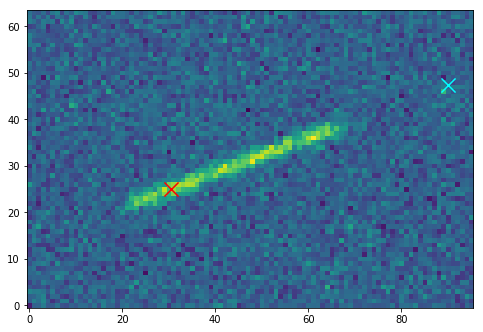

In [4]:
# Check the calculated end and start points.
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(im, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

(x1, y1), (x2, y2) = line_fit_tips
ax.scatter(y1, x1, color='red', s=200, marker="x")
ax.scatter(y2, x2, color='cyan', s=200, marker="x")

In [5]:
# Now we compute all the points contained
# in the line separated by a defined distance (`spacing`).

# We like to use a spacing < 1 pixel to get 
# subpixel resolution accuracy during fitting.

spacing = 0.1  # pixel
points = anamic.geometry.discretize_line(line_fit_tips, spacing)

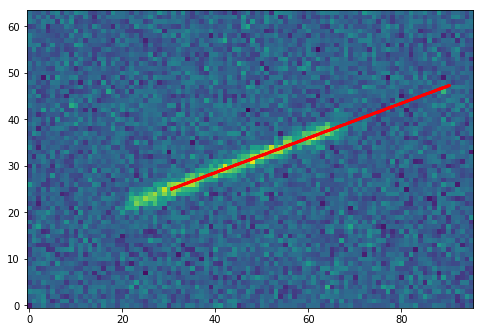

In [6]:
# Check the points
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(im, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

ax.scatter(points[:, 1], points[:, 0], color='red', s=10, marker=".")

In [7]:
# Get the points parallel to the list of points
# located at a certain distance from the line.

line_thickness = 200  # nm
line_thickness_pixel = line_thickness / pixel_size
normal_distance = line_thickness_pixel / 2

vec = points[-1] - points[0]

normal_points = anamic.geometry.get_normal_points(vec, points, normal_distance)

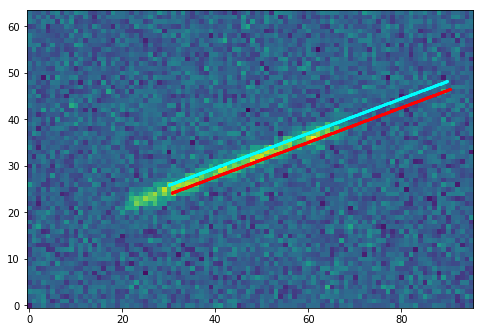

In [8]:
# Check the new points.
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(im, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

ax.scatter(normal_points[0, 1], normal_points[0, 0], color='red', s=10, marker=".")
ax.scatter(normal_points[1, 1], normal_points[1, 0], color='cyan', s=10, marker=".")

In [9]:
# Now we generate all the points located on the
# lines defined by `normal_points` with a defined spacing.

line_thickness_spacing = 0.1  # pixel

lines = []

# Iterate over the length of the microtubule.
for p1, p2 in np.rollaxis(normal_points, -1):
    line = np.array([p1, p2])
    points = anamic.geometry.discretize_line(line, line_thickness_spacing)
    lines.append(points)
lines = np.array(lines).T

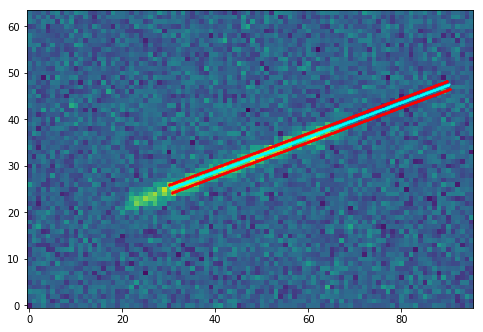

In [10]:
# Check the new points.
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(im, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

ax.scatter(lines[1, 0], lines[0, 0], color='red', s=5, marker=".")
ax.scatter(lines[1, -1], lines[0, -1], color='red', s=5, marker=".")

middle_index = int(lines.shape[1] / 2)
ax.scatter(lines[1, middle_index], lines[0, middle_index], color='cyan', s=5, marker=".")

(0.6, 1.1)

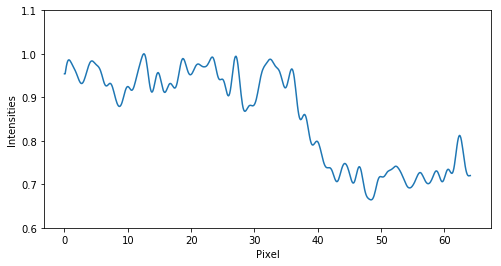

In [11]:
# Get the intensity profile of the lines.
y_profiles = ndimage.map_coordinates(im, lines.reshape(2, -1), order=3, mode='constant')
y_profiles = y_profiles.reshape(lines.shape[1:])

# Get the mean profile
y_profile = y_profiles.mean(axis=0)

# Normalize the profile between 0 and 1.
# FUTURE: could be modified.
y_profile = y_profile / y_profile.max()

# Define the x values of the profile so the unit is a pixel.
x_profile = np.arange(0, y_profile.shape[0]) * spacing

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(x_profile, y_profile)
ax.set_xlabel("Pixel")
ax.set_ylabel("Intensities")
ax.set_ylim(0.6, 1.1)